In [12]:
import torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from mmd import MMD_3_Sample_Test
from train_vae import train_vae, MNISTDataset

seed=42
np.random.seed(seed)

## Get models

In [34]:
dataset = MNISTDataset(train=False)

In [17]:
train = lambda latent_dim, hidden_dim=None, train_size=None: train_vae(
        ds_name='mnist',
        in_dim=28*28,
        latent_dim=latent_dim,
        hidden_dim = hidden_dim,
        train_size = train_size,
        device = "cuda",
        save_dir = None,
    )

In [18]:
VAE1 = train(512)

output_dir: ./mnist_784_512_None


In [19]:
VAE2 = train(256)

output_dir: ./mnist_784_256_None


In [22]:
def reduce_dim(X, new_dim = None):
    if new_dim is None:
        return X
    pca = PCA(new_dim)
    X_pca = pca.fit_transform(X)
    return X_pca

In [35]:
def extract_data(dataset, vae1, vae2, count, new_dim=None):
    idx = np.random.choice(len(dataset), N, replace=False)
    X = dataset.data[idx]
    
    prior = torch.randn(count, vae1.latent_dim, device=vae1.device)
    Y = vae1.decoder(prior).cpu().detach().numpy()
    
    prior = torch.randn(count, vae2.latent_dim, device=vae2.device)
    Z = vae2.decoder(prior).cpu().detach().numpy()
    return reduce_dim(X, new_dim), reduce_dim(Y, new_dim), reduce_dim(Z, new_dim)

In [38]:
N = 1000
dim = None
X, Y, Z = extract_data(dataset, VAE1, VAE2, N, dim)

In [39]:
mmd = MMD_3_Sample_Test(X, Y, Z)
pvalue, _, _, _, _ = mmd
print(pvalue)

0.9999999713951002


P-value is small - reject Null-hypothesis, therefore the first model is better. That's true (latent space is much bigger

In [29]:
# sanity-check: if we sample from the same model, p-value should be high
X, Y, Z = extract_data(dataset, VAE2, VAE2, N, dim)
mmd = MMD_3_Sample_Test(X, Y, Z)
pvalue, _, _, _, _ = mmd
print(pvalue)
assert pvalue  > 0.1

0.43992528050229845


In [30]:
# sanity-check: if we give samples from the same dataset, it should give high p-value
N = 10_000

idx = np.random.choice(len(dataset), N, replace=False)
X = dataset.data[idx]
idx = np.random.choice(len(dataset), N, replace=False)
Y = dataset.data[idx]
prior = torch.randn(N, VAE2.latent_dim, device=VAE2.device)
Z = VAE2.decoder(prior).cpu().detach().numpy()

mmd = MMD_3_Sample_Test(reduce_dim(X, dim), reduce_dim(Y, dim), reduce_dim(Z, dim))
pvalue, _, _, _, _ = mmd
print(pvalue)

1.0


## Experiments
Let's try train models with different parameters and see, how that affects the results

In [41]:
# Fix large N, to make tests more "stable"
N = 5_000

# VAE2 is fixed with hidden_size=400 and latent=20
VAE2 = train(20, 400)
# hidden_space and latent for VAE1
grid = [(200, 5), (200, 20), (400, 20), (800, 20), (800, 20)]

results = []
for hidden_dim, latent_dim in grid:
    VAE1 = train(latent_dim=latent_dim,
                 hidden_dim=hidden_dim)
    X, Y, Z = extract_data(dataset, VAE1, VAE2, N, new_dim=15)
    mmd = MMD_3_Sample_Test(reduce_dim(X, dim), reduce_dim(Y, dim), reduce_dim(Z, dim))
    results.append(mmd)
    print(f"latent_dim={latent_dim}, hidden_dim={hidden_dim}, p_val={mmd[0]:.5f}")

output_dir: ./mnist_784_20_400
output_dir: ./mnist_784_5_200
latent_dim=5, hidden_dim=200, p_val=0.00000
output_dir: ./mnist_784_20_200
latent_dim=20, hidden_dim=200, p_val=0.00000
output_dir: ./mnist_784_20_400
latent_dim=20, hidden_dim=400, p_val=0.26771
output_dir: ./mnist_784_20_800
latent_dim=20, hidden_dim=800, p_val=0.99475
output_dir: ./mnist_784_20_800
latent_dim=20, hidden_dim=800, p_val=0.99475


In [43]:
print('latent_dim=5, hidden_dim=200, p_val=0.00000')
print('latent_dim=20, hidden_dim=200, p_val=0.00000')
print('latent_dim=20, hidden_dim=400, p_val=0.26771')
print('latent_dim=20, hidden_dim=800, p_val=0.99475')
print('latent_dim=20, hidden_dim=800, p_val=0.99475')

latent_dim=5, hidden_dim=200, p_val=0.00000
latent_dim=20, hidden_dim=200, p_val=0.00000
latent_dim=20, hidden_dim=400, p_val=0.26771
latent_dim=20, hidden_dim=800, p_val=0.99475
latent_dim=20, hidden_dim=800, p_val=0.99475


In [46]:
ref = 'mnist_784_20_400'
steps = ['mnist_784_5_200', 'mnist_784_20_200', 'mnist_784_20_400', 'mnist_784_20_800', 'mnist_784_20_800']

In [47]:
import subprocess

for st in steps:
    subprocess.run(["python", "compute_accuracy.py", st])

In [51]:
accs = []
for st in steps:
    with open(f"{st}/accuracy.txt", 'r') as f:
        acc = float(f.read())
        accs.append(acc)

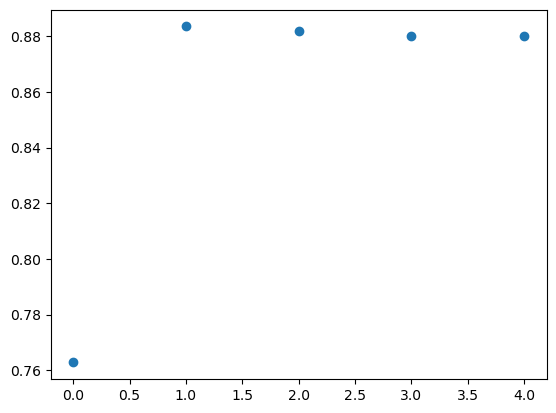

In [52]:
plt.scatter(range(len(accs)), accs)
plt.show()